Refer this blog: https://medium.com/the-owl/recommender-systems-

# Step 1: Connect to Snowflake 

In [7]:
import os 
from pathlib import Path 
from dotenv import load_dotenv
import snowflake.snowpark.functions as F 
import snowflake.snowpark.types as T 

from utils import build_snowflake_session


# Build the .env full path 
env_path = Path(os.getcwd()).parent / ".env"
# Load the .env file 
load_dotenv(env_path) 

# Get connection credentials 
config_params  = {
    "account": os.getenv("SNOWFLAKE_ACCOUNT"),
    "user": os.getenv("SNOWFLAKE_USER"),
    "password": os.getenv("SNOWFLAKE_PASSWORD"),
    "role": "ML_MODEL_ROLE",
    "warehouse": "ML_MODEL_WH",
    "database": "ML_MODEL_DATABASE",
    "schema": "MOVIE_RECSYS",
    }

session = build_snowflake_session(config_params)


# Step 1: Load the movie datasets and write them to Snowflake tables

In [8]:
import numpy as np 
import pandas as pd 
from snowflake.connector.pandas_tools import write_pandas

credits = pd.read_csv("data/movie/tmdb_5000_credits.csv")
movies = pd.read_csv("data/movie/tmdb_5000_movies.csv")

session.sql("USE CURRENT_DATABASE()")
session.sql("USE CURRENT_SCHEMA()")



credits_df = session.create_dataframe(credits)
# Rename columns to remove double quotes 
credits_df = (credits_df
              .select(*[F.col(col_name).alias(col_name.strip('"')) for col_name in credits_df.columns]))
#.write.mode("overwrite").save_as_table("tmdb_5000_credits")
movies_df = session.create_dataframe(movies)
movies_df = (movies_df
              .select(*[F.col(col_name).alias(col_name.strip('"')) for col_name in movies_df.columns]))
#.write.mode("overwrite").save_as_table("tmdb_5000_movies")

print(credits_df.schema)
print(movies_df.schema)

StructType([StructField('MOVIE_ID', LongType(), nullable=True), StructField('TITLE', StringType(), nullable=True), StructField('CAST', StringType(), nullable=True), StructField('CREW', StringType(), nullable=True)])
StructType([StructField('BUDGET', LongType(), nullable=True), StructField('GENRES', StringType(), nullable=True), StructField('HOMEPAGE', StringType(), nullable=True), StructField('ID', LongType(), nullable=True), StructField('KEYWORDS', StringType(), nullable=True), StructField('ORIGINAL_LANGUAGE', StringType(), nullable=True), StructField('ORIGINAL_TITLE', StringType(), nullable=True), StructField('OVERVIEW', StringType(), nullable=True), StructField('POPULARITY', DoubleType(), nullable=True), StructField('PRODUCTION_COMPANIES', StringType(), nullable=True), StructField('PRODUCTION_COUNTRIES', StringType(), nullable=True), StructField('RELEASE_DATE', StringType(), nullable=True), StructField('REVENUE', LongType(), nullable=True), StructField('RUNTIME', DoubleType(), nulla

In [9]:
# Write to Snowflake tables
credits_df.write.mode("overwrite").save_as_table("tmdb_5000_credits")
movies_df.write.mode("overwrite").save_as_table("tmdb_5000_movies")


# Step 2: Load data again 

In [10]:
import snowflake.snowpark.functions as F 

credits_df = (session
              .table("TMDB_5000_CREDITS")
              .with_column_renamed("movie_id", "id"))
credits_df.show(5)

# Merge credits and movies table 
movies_df = session.table("tmdb_5000_movies")
movies_df.show(5)

movies_credits_df = (movies_df.join(credits_df, "id"))

credits_df.count(), movies_df.count(), movies_credits_df.count()

---------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ID"    |"TITLE"                                   |"CAST"                                              |"CREW"                                              |
---------------------------------------------------------------------------------------------------------------------------------------------------------------
|19995   |Avatar                                    |[{"cast_id": 242, "character": "Jake Sully", "c...  |[{"credit_id": "52fe48009251416c750aca23", "dep...  |
|285     |Pirates of the Caribbean: At World's End  |[{"cast_id": 4, "character": "Captain Jack Spar...  |[{"credit_id": "52fe4232c3a36847f800b579", "dep...  |
|206647  |Spectre                                   |[{"cast_id": 1, "character": "James Bond", "cre...  |[{"credit_id": "54805967c3a36829b5002c41", "dep...  |
|49026   |The Dark Knight Rises         

(4803, 4803, 4803)

# Popularity Based Filtering 

As the name suggets, Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that items to the user who just signed up. 

## IMDB weighted avg formula:

Weighted Rating(WR)=[vR/(v+m)]+[mC/(v+m)]

where,
- v is the number of votes for the movie;
- m is the minimum votes required to be listed in the chart;
- R is the average rating of the movie; and
- C is the mean vote across the whole report.

Now we find the values of v,m,R,C.


In [87]:
C = movies_credits_df.select(F.avg("vote_average").alias("mean_value")).collect()[0][0]
print(C)
m = movies_credits_df.select(F.approx_percentile("vote_count", 0.9).alias("quantile_90")).collect()[0][0]
print(m)
q_movies_df = movies_credits_df.where(F.col("vote_count") >= m)
q_movies_df.count()

6.092171559442016
1843.1187499999985


480

Here we used 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes thatn at least 90% of the movies in the list. 

We see that there are 480 movies which qualify to be in this list. Now, we need to calculate our metric for each qualified movie. We will define a function, wieghted_rating() and define a new feature score, of which we will calculate the value by applying this function to our DataFrame of qualified movies: 

In [104]:
movies_credits_df.schema

StructType([StructField('ID', LongType(), nullable=True), StructField('BUDGET', LongType(), nullable=True), StructField('GENRES', StringType(), nullable=True), StructField('HOMEPAGE', StringType(), nullable=True), StructField('KEYWORDS', StringType(), nullable=True), StructField('ORIGINAL_LANGUAGE', StringType(), nullable=True), StructField('ORIGINAL_TITLE', StringType(), nullable=True), StructField('OVERVIEW', StringType(), nullable=True), StructField('POPULARITY', DoubleType(), nullable=True), StructField('PRODUCTION_COMPANIES', StringType(), nullable=True), StructField('PRODUCTION_COUNTRIES', StringType(), nullable=True), StructField('RELEASE_DATE', StringType(), nullable=True), StructField('REVENUE', LongType(), nullable=True), StructField('RUNTIME', DoubleType(), nullable=True), StructField('SPOKEN_LANGUAGES', StringType(), nullable=True), StructField('STATUS', StringType(), nullable=True), StructField('TAGLINE', StringType(), nullable=True), StructField('"l_cdxn_TITLE"', StringTy

In [115]:
import snowflake.snowpark.types as T 



C = 6.092171559442016
M =1843.1187499999985


def weighted_rating(vote_count: int, vote_average: float) -> float: 
    v = vote_count
    R = vote_average
    return (v/(v+M) * R) + (M/(M+v) * C)

# Important: Register the UDF explicitly with the session 
weighted_rating_udf = session.udf.register(weighted_rating, 
                                           return_type=T.FloatType(), 
                                           input_types=[T.DoubleType(), T.FloatType()])
# Apply the UDF to the DataFrame
q_movies_df = (q_movies_df
               .with_column("score", weighted_rating_udf(F.col("vote_count"), F.col("vote_average"))))


# Sort movies based on score calculated above 
q_movies_df = q_movies_df.order_by(F.col("score").desc())
# show top 15 movies 
q_movies_df.select("original_title", "vote_count", "vote_average", "score").show(15)


----------------------------------------------------------------------------------------------------------
|"ORIGINAL_TITLE"                                   |"VOTE_COUNT"  |"VOTE_AVERAGE"  |"SCORE"             |
----------------------------------------------------------------------------------------------------------
|The Shawshank Redemption                           |8205          |8.5             |8.058333867662972   |
|Fight Club                                         |9413          |8.3             |7.938481959372038   |
|The Dark Knight                                    |12002         |8.2             |7.919397269844604   |
|Pulp Fiction                                       |8428          |8.3             |7.903812389417106   |
|Inception                                          |13752         |8.1             |7.862703554560899   |
|The Godfather                                      |5893          |8.4             |7.850163317286762   |
|Interstellar                        

# Visualization 

Now we visualize the top 6 movies according to Popularity based recommendation system. 

            ORIGINAL_TITLE  POPULARITY
0                  Minions  875.581305
1             Interstellar  724.247784
2                 Deadpool  514.569956
3  Guardians of the Galaxy  481.098624
4       Mad Max: Fury Road  434.278564
5           Jurassic World  418.708552


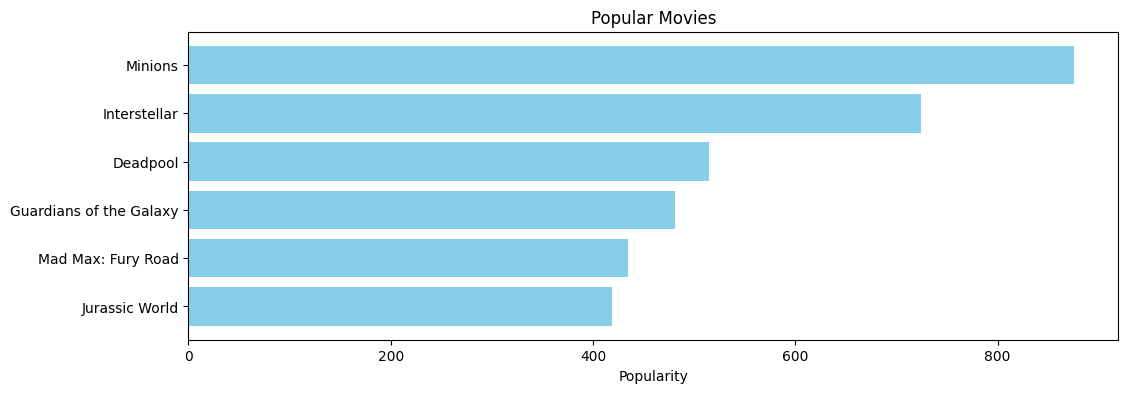

In [123]:
import matplotlib.pyplot as plt 

popularity_df = movies_credits_df.order_by(F.col("popularity").desc())

# Select the top 6 rows from the DataFrame, skipping offset rows from the begining 
selected_pd = popularity_df.select("original_title", "popularity").limit(6).to_pandas()

print(selected_pd)

plt.figure(figsize=(12, 4))

plt.barh(selected_pd["ORIGINAL_TITLE"], selected_pd["POPULARITY"], align="center", color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

plt.show()



# Content Based Filtering 

In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended. 

## Plot description based Recommender: 
We will compute pairwise similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score. The plot description is given in the "overview" feature of our dataset. 

* sklearn.feature_extraction.text.TfidfVectorizer Overview
The TfidfVectorizer in scikit-learn is used to convert a collection of text documents into a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features. It is a key tool for text preprocessing and feature extraction in natural language processing (NLP) tasks.

Key Concepts:
TF-IDF: The combination of:

Term Frequency (TF): The number of times a term (word) appears in a document.
Inverse Document Frequency (IDF): The inverse of the number of documents containing the term. It downweights common terms that appear in many documents.
The formula for TF-IDF is:

![Screenshot 2024-11-19 at 11.13.23.png](<attachment:Screenshot 2024-11-19 at 11.13.23.png>)


Purpose: TF-IDF is used to assess the importance of words in a document relative to a collection of documents. It is helpful for tasks like:

  - Text classification
  - Information retrieval
  - Document clustering

TfidfVectorizer Parameters:
  - input: Defines the input type, can be file, filename, content (default: content).
  - encoding: Character encoding used to decode the input text.
  - stop_words: Words to ignore (e.g., common stop words like "the", "and").
  - ngram_range: The range of n-values for n-grams (tuples of words), default is (1, 1) for unigrams.
  - max_features: Limit on the number of features (terms) to extract.
  - min_df: Minimum document frequency for a term to be included (e.g., ignore terms that appear in fewer than min_df documents).
  - max_df: Maximum document frequency (e.g., ignore terms that appear in more than max_df proportion of documents).
  - norm: Normalization method for the TF-IDF scores (e.g., l2, l1).
  - use_idf: Whether to use inverse document frequency (default is True).
  - smooth_idf: Adds a smoothing factor to the IDF term to avoid division by zero.
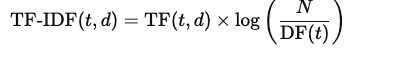

In [130]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define a TF-IDF Vectorizer Object. Remove all english stop words such as "the", "a"
tfidf = TfidfVectorizer(stop_words="english")

# Replacing NaN with an empty string 
movies_credits_df = movies_credits_df.fillna({"overview": ""})

movies_credits_df.select("overview").show()

# Convert Snowpark DataFrame to Pandas dataframe 
movies_credits_pd = movies_credits_df.to_pandas()

# Constructing the required TF-IDF matrix by fitting and transforming the data 
tfidf_matrix = tfidf.fit_transform(movies_credits_pd["OVERVIEW"])   # Case sensitive 

# Output the shape of tfidf_matrix 
tfidf_matrix.shape

------------------------------------------------------
|"OVERVIEW"                                          |
------------------------------------------------------
|In the 22nd century, a paraplegic Marine is dis...  |
|Captain Barbossa, long believed to be dead, has...  |
|A cryptic message from Bond’s past sends him on...  |
|Following the death of District Attorney Harvey...  |
|John Carter is a war-weary, former military cap...  |
|The seemingly invincible Spider-Man goes up aga...  |
|When the kingdom's most wanted-and most charmin...  |
|When Tony Stark tries to jumpstart a dormant pe...  |
|As Harry begins his sixth year at Hogwarts, he ...  |
|Fearing the actions of a god-like Super Hero le...  |
------------------------------------------------------



(4803, 20978)

We see that 20978 different words were used to describe the 4803 movies in our dataset. 

With this matrix, we compute a similarity score. We wil be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. 
Mathematically, it is defined as follows: 

![](<attachment:Screenshot 2024-11-19 at 11.33.35.png>)

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's linear_kernel() instead of cosine_similarity() since it is faster. 

Why linear_kernel() is a good choice here:
Dot product = Cosine similarity (for unit vectors): Since the TF-IDF vectors are generally normalized (with each document vector having a magnitude of 1), the dot product between two such vectors directly gives the cosine similarity score.
Efficiency: The linear_kernel() function is computationally faster than cosine_similarity() because:
linear_kernel() only computes the dot product between two vectors.
cosine_similarity(), on the other hand, involves computing the dot product and normalizing the vectors to unit length (which requires additional computation). If the vectors are already normalized (as is typical with TF-IDF vectors), this normalization step becomes redundant, and linear_kernel() is just as accurate but faster.
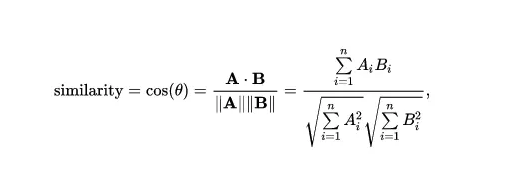

In [131]:
# Import linear_kernel 
from sklearn.metrics.pairwise import linear_kernel

# Computing the cosine similarity matrix 
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


Now we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title. 

In [132]:
# Constructing a revse map of incies and movie titles 
indices = pd.Series(movies_credits_pd.index, index=movies_credits_pd["ORIGINAL_TITLE"]).drop_duplicates()

pd.DataFrame(indices).head()

,0
ORIGINAL_TITLE,
Avatar,0
Pirates of the Caribbean: At World's End,1
Spectre,2
The Dark Knight Rises,3
John Carter,4


Now we need to follow the steps for defining our recommendation function: 
* Get the index of the movie given its title 
* Get the list of cosine similarity scores for that particular movie with all movies. 
* Convert it into a list of tuples where the first element is its position and the second is the similarity socre. 
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element. 
* Get the top 10 elements of this list. Ignore the first element as it refers to itself (the movie most similar to a particular movie is the movie itself.)
* Return the titles correpsonding to the indices of the top elements. 

In [133]:
def get_recommendation(title, cosine_sim=cosine_sim): 
    # Get the index of the movie given its title
    idx = indices[title]
    # Get the list of cosine similarity scores 
    sim_scores = list(enumerate(cosine_sim[idx]))
    # Sort based on sim_score 
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores of the top 10 most similar movies 
    sim_scores = sim_scores[1:11]
    # Get the indices of movies 
    sim_scores = [i[0] for i in sim_scores]
    
    return movies_credits_pd["ORIGINAL_TITLE"].iloc[sim_scores]


In [134]:
# Test the results: 

get_recommendation("The Matrix")

1281                  Hackers
2996                 Commando
2088                    Pulse
1341         Obitaemyy Ostrov
333             Transcendence
0                      Avatar
261     Live Free or Die Hard
775                 Supernova
125       The Matrix Reloaded
2614          The Love Letter
Name: ORIGINAL_TITLE, dtype: object

In [135]:
get_recommendation("Superman")

870                          Superman II
10                      Superman Returns
2433    Superman IV: The Quest for Peace
914                 Central Intelligence
4659                          Horse Camp
2527         National Lampoon's Vacation
3542                                R100
45                           World War Z
1368                      Identity Thief
1237                  The Out-of-Towners
Name: ORIGINAL_TITLE, dtype: object

# Credits, Genres and Keywords Based Recommender 

We are going to build a recommender based on the following: 
the top 3 actors, the director, related genres and the movie plot keywords. 
From the cast, crew and keywords features, we need to extract the three most important actors, the director and the keywords associated with that movie. 
Right now, our data is present in the form of "stringfield" lists, we need to convert is into a safe and usable structure. 


## ast: Abstract Syntax Trees 
The literal_eval function from the ast module is used to safely evaluate a string containing a Python liternal expression. It can parse and evalaute strings that represent Python literal structures such as : 

* Strings
* Numbers
* Tuples
* Lists
* Dictionaries
* Booleans

It only evaluates literal expressions (those that represent basic Python data types) and does not execute arbitrary code, making it safer than the eval() function, which can execute arbitrary Python code.

Common Use Case:
If you have a string that represents a Python literal (e.g., a list or dictionary), and you want to convert it into the corresponding Python object, literal_eval can be used.

Important Points:
Safety: Unlike eval(), which can execute arbitrary code, literal_eval only evaluates valid Python literals (e.g., numbers, strings, tuples, lists, dictionaries, booleans, None).
Common Use Cases:
Converting string representations of lists, dictionaries, or other literals back into their actual Python objects.
Parsing configurations or user input that might contain such literals.



In [11]:
movies_credits_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ID"    |"BUDGET"  |"GENRES"                                            |"HOMEPAGE"                              |"KEYWORDS"                                          |"ORIGINAL_LANGUAGE"  

In [12]:
from ast import literal_eval

features = ["cast", "crew", "keywords", "genres"]

# Define a function that uses literal_eval 
def apply_literal_eval(feat: str): 
    return literal_eval(feat) if feat else []

# Important: Register the UDF explicitly with the session 
apply_literal_eval_udf = session.udf.register(apply_literal_eval, 
                                              return_type=T.StringType(), 
                                              input_types=[T.StringType()])

# Apply the UDF to the relevant columns in the Snowpark DataFrame 
df_copy = movies_credits_df
for feat in features:
    transformed_df = df_copy.with_column(feat, apply_literal_eval_udf(F.col(feat).cast(T.StringType())))

transformed_df.show()


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ID"    |"BUDGET"  |"HOMEPAGE"                              |"KEYWORDS"                                          |"ORIGINAL_LANGUAGE"  |"ORIGINAL_TITLE"                                 |"O

In [13]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(crew):
    for item in crew: 
        if item["job"] == "Director":
            return item["name"]
    return None

# Important: Register the UDF explicitly with the session 
get_director_udf = session.udf.register(get_director, 
                                        return_type=T.VariantType(), 
                                        input_types=[T.VariantType()])


# Parse the JSON string column into a VARIANT type 
parsed_crew_df = (transformed_df
                  .with_column("crew", F.parse_json("crew")))

movie_director_df = parsed_crew_df.with_column("director", get_director_udf(F.col("crew")))

movie_director_df.select("id", "original_title", "director").show(10)

#parsed_crew_df.count(), movie_director_df.count()

--------------------------------------------------------------------------------------
|"ID"    |"ORIGINAL_TITLE"                                 |"DIRECTOR"               |
--------------------------------------------------------------------------------------
|44639   |Inside Job                                       |"Charles Ferguson"       |
|301351  |We Are Your Friends                              |"Max Joseph"             |
|4816    |Ghost Dog: The Way of the Samurai                |"Jim Jarmusch"           |
|7873    |Harsh Times                                      |"David Ayer"             |
|331190  |Captive                                          |"Jerry Jameson"          |
|15186   |Full Frontal                                     |"Steven Soderbergh"      |
|17994   |Witchboard                                       |"Kevin Tenney"           |
|1378    |Shortbus                                         |"John Cameron Mitchell"  |
|8885    |Vals Im Bashir                   

In [14]:
features = ["cast", "keywords", "genres"]

parsed_df = movie_director_df
for feat in features:
    parsed_df = (parsed_df
                  .with_column(feat, F.parse_json(feat)))


#parsed_df.select(features).show(5)
#parsed_df.select(features).schema

# Only keep the first three elements in each column 
def get_list(col):
    if isinstance(col, list): 
        names = [i["name"] for i in col]
        # Check if more than 3 elements exist. If yes, return only first three. If  no, return entire list. 
        if len(names) > 3:
            names = names[:3]
        return names 
    
    # return empty list in case of missing/malformed data
    return []

# Important: Register the UDF explicitly with the session 
get_list_udf = session.udf.register(get_list, 
                                        return_type=T.VariantType(), 
                                        input_types=[T.VariantType()])

top_three_df = parsed_df
for feat in features: 
    top_three_df = top_three_df.with_column(feat, get_list_udf(F.col(feat)))

top_three_df.select("id", "original_title", *features).show(5)


--------------------------------------------------------------------------------------------------------------------------
|"ID"    |"ORIGINAL_TITLE"                   |"CAST"                        |"KEYWORDS"                |"GENRES"         |
--------------------------------------------------------------------------------------------------------------------------
|44639   |Inside Job                         |[                             |[                         |[                |
|        |                                   |  "Matt Damon",               |  "corruption",           |  "Documentary"  |
|        |                                   |  "William Ackman",           |  "capitalism",           |]                |
|        |                                   |  "Barack Obama"              |  "globalization"         |                 |
|        |                                   |]                             |]                         |                 |
|301351  |We Are

The next step is to convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that the vectorizer does not count the Johnny of "Johnny Depp" and "Johnny Galecki" at the same . 

In [15]:
top_three_df.select("director", "cast", "keywords", "genres").show(5)

--------------------------------------------------------------------------------------------------
|"DIRECTOR"          |"CAST"                        |"KEYWORDS"                |"GENRES"         |
--------------------------------------------------------------------------------------------------
|"Charles Ferguson"  |[                             |[                         |[                |
|                    |  "Matt Damon",               |  "corruption",           |  "Documentary"  |
|                    |  "William Ackman",           |  "capitalism",           |]                |
|                    |  "Barack Obama"              |  "globalization"         |                 |
|                    |]                             |]                         |                 |
|"Max Joseph"        |[                             |[                         |[                |
|                    |  "Zac Efron",                |  "dj"                    |  "Drama",       |
|         

In [16]:
def clean_data(col): 
    if isinstance(col, list):
        return [i.replace(" ", "").lower() for i in col]
    else:
        # Check if director exists. if not, return empty string
        if isinstance(col, str):
            return col.replace(" ", "").lower()
        else: 
            return ''
        
# Important: Register the UDF explicitly with the session 
clean_data_udf = session.udf.register(clean_data, 
                                      return_type=T.VariantType(), 
                                      input_types=[T.VariantType()])

columns_to_clean = ["cast", "keywords", "director", "genres"]
cleaned_df = top_three_df
for col in columns_to_clean:
    cleaned_df = cleaned_df.with_column(col, clean_data_udf(col))

cleaned_df.select("id", "original_title", "cast", "keywords", "director", "genres").show(5)
 
# Apply clean_data function to the features. 

-----------------------------------------------------------------------------------------------------------------------------------------
|"ID"    |"ORIGINAL_TITLE"                   |"CAST"                      |"KEYWORDS"             |"DIRECTOR"         |"GENRES"         |
-----------------------------------------------------------------------------------------------------------------------------------------
|44639   |Inside Job                         |[                           |[                      |"charlesferguson"  |[                |
|        |                                   |  "mattdamon",              |  "corruption",        |                   |  "documentary"  |
|        |                                   |  "williamackman",          |  "capitalism",        |                   |]                |
|        |                                   |  "barackobama"             |  "globalization"      |                   |                 |
|        |                        

Now we create our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer (namely actors, director and keywords).

In [17]:
def create_soup(keywords, cast, director,genres):
    return ' '.join(keywords) + ' ' + ' '.join(cast) + ' ' + director + ' ' + ' '.join(genres)

# register the UDF 
creat_soup_udf = session.udf.register(create_soup, 
                                      return_type=T.StringType(), 
                                      input_types=[T.VariantType(), 
                                                   T.VariantType(),
                                                   T.VariantType(),
                                                   T.VariantType()])

final_df = cleaned_df
final_df = cleaned_df.with_column("soup", creat_soup_udf(F.col("keywords"), 
                                                         F.col("cast"), 
                                                         F.col("director"), 
                                                         F.col("genres")))

final_df.select("id", "original_title", "soup").show(5)

---------------------------------------------------------------------------------------------------
|"ID"    |"ORIGINAL_TITLE"                   |"SOUP"                                              |
---------------------------------------------------------------------------------------------------
|44639   |Inside Job                         |corruption capitalism globalization mattdamon w...  |
|301351  |We Are Your Friends                |dj zacefron emilyratajkowski wesbentley maxjose...  |
|4816    |Ghost Dog: The Way of the Samurai  |deportation hitman missionofmurder forestwhitak...  |
|7873    |Harsh Times                        |watchingamovie playingpool vinegar christianbal...  |
|331190  |Captive                            |hostage basedontruestory murder katemara davido...  |
---------------------------------------------------------------------------------------------------



The next steps are the same as what we did with out plot description based recommender. One important difference is that we use the CountVectorizer() instead of TF-IDF. This is because we do not want to downweight the presence of an actor/director if he or she has acted or directed in relatively more movies. It does not make much intuitive sense. 

In [29]:
# Import CountVectorizer and create the count matrix 
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words="english")
final_pd = final_df.to_pandas()
count_matrix = count.fit_transform(final_pd["SOUP"])   # case sensitive
print("count_matrix is \n")
print(count_matrix)

# Compute the Cosine Similarity matrix based on the count_matrix 
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

indices = pd.Series(final_pd.index, index=final_pd["ORIGINAL_TITLE"])    # Case sensitive 

count_matrix is 

  (0, 2255)	1
  (0, 3710)	1
  (0, 10002)	1
  (0, 9443)	1
  (0, 11495)	1
  (0, 9841)	1
  (0, 4764)	1
  (0, 40)	1
  (0, 111)	1
  (0, 3421)	1
  (1, 40)	1
  (1, 111)	1
  (1, 3421)	1
  (1, 7961)	1
  (1, 2937)	1
  (1, 3348)	1
  (1, 5385)	1
  (1, 8041)	1
  (1, 5879)	1
  (1, 4005)	1
  (2, 40)	1
  (2, 111)	1
  (2, 10039)	1
  (2, 868)	1
  (2, 9625)	1
  :	:
  (4799, 9201)	1
  (4799, 3050)	2
  (4799, 5941)	1
  (4799, 6899)	1
  (4800, 2921)	1
  (4800, 2082)	1
  (4800, 9201)	1
  (4800, 2444)	1
  (4800, 7671)	1
  (4800, 6560)	1
  (4800, 3242)	1
  (4800, 6099)	1
  (4800, 2249)	1
  (4800, 9573)	1
  (4801, 2355)	1
  (4801, 1052)	1
  (4801, 3120)	1
  (4801, 2356)	1
  (4802, 7957)	1
  (4802, 2926)	1
  (4802, 2812)	1
  (4802, 1468)	1
  (4802, 2247)	1
  (4802, 2153)	1
  (4802, 1289)	2


In [30]:
print(indices)

ORIGINAL_TITLE
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64


In [31]:
print(cosine_sim2)

[[1.  0.3 0.2 ... 0.  0.  0. ]
 [0.3 1.  0.2 ... 0.  0.  0. ]
 [0.2 0.2 1.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 1.  0.  0. ]
 [0.  0.  0.  ... 0.  1.  0. ]
 [0.  0.  0.  ... 0.  0.  1. ]]


In [32]:
def get_recommendation_cosine_sim(title, cosine_sim=cosine_sim2): 
    # Get the index of the movie given its title 
    idx = indices[title]
    print("title is: {} and idx is: {}".format(title, idx))
    # Get the list of cosine similarity scores 
    sim_scores = list(enumerate(cosine_sim[idx]))
    # Sort based on sim_score 
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores of the top 10 most similar movies 
    sim_scores = sim_scores[1: 11]
    # Get the movie indices 
    sim_scores = [i[0] for i in sim_scores]
    return final_pd["ORIGINAL_TITLE"].iloc[sim_scores]

In [33]:
get_recommendation_cosine_sim("Fight Club", cosine_sim2)

title is: Fight Club and idx is: 662


100     The Curious Case of Benjamin Button
2058                                  Stone
928                               Moneyball
1161                     The Social Network
2133                                  Babel
4564               Straight Out of Brooklyn
1446                       The Tree of Life
2276                       The Painted Veil
2838                 The Fault in Our Stars
3043                       End of the Spear
Name: ORIGINAL_TITLE, dtype: object

In [35]:
get_recommendation_cosine_sim("The Godfather", cosine_sim2)

title is: The Godfather and idx is: 3337


867      The Godfather: Part III
2731      The Godfather: Part II
4638    Amidst the Devil's Wings
2649           The Son of No One
1525              Apocalypse Now
1018             The Cotton Club
1170     The Talented Mr. Ripley
1209               The Rainmaker
1394               Donnie Brasco
1850                    Scarface
Name: ORIGINAL_TITLE, dtype: object

# Collaborative Filtering 

The content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to certain movies. That is, it is not capable of capturing tastes and providing recommendations across genres. 
Also, the engine that is built is not really personal in that it does not capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is. 

Then we will use a technique called Collaborative Filtering to make recommendations to Movie Watchers. It is basically two types: 

* User based filtering - These systems recommend products to a user that similar users have liked. For measuring the similarity between two users we can either use pearson correlation or cosine similarity. 
Although computing user-based CF is very simple, it suffers from several problems. One main issus is that users' preference can change over time. It indicates that precomputing the matrix based on their neighboring users may lead to bad performance. To tackle this problem, we can apply item-based CF. 

* Item Based Collaborative Filtering - Instead of measuring the similarity between uses, the item-based CF recommends items based on their similarity with the items that the target user rated. Likewise, the similarity can be computed with Pearson Correlation or Cosine Similarity. 
It successfully avoids the problem posed by dynamic user preference as item-based CF is more static. However, several problems remain for this method. 
First, the main issue is scalability. The computation grows with both the customer and the product. The worse case complexity is O(mn) with m users and n items. In addition, sparsity is another concern. In extreme cases, we can have millions of users and the similarity between two fairly different movies could be very high simply because they have similar rank for the only user who marked them both. 

## Single Value Decomposition

One way to handle the scalability and sparsity issue created by CF is to leverage a latent factor model to capture the similarity between users and items. Essentially, we want to turn the recommendation problem into an optimization problem. We can view it as how good we are in predicting the rating for items given a user. One common metric is Root Mean Square Error (RMSE). The lower the RMSE, the better the performance.

Now talking about latent factor you might be wondering what is it ?It is a broad idea which describes a property or concept that a user or an item have. For instance, for music, latent factor can refer to the genre that the music belongs to. SVD decreases the dimension of the utility matrix by extracting its latent factors. Essentially, we map each user and each item into a latent space with dimension r. Therefore, it helps us better understand the relationship between users and items as they become directly comparable.

Now enough said , let’s see how to implement this. Since the dataset we used before did not have userId(which is necessary for collaborative filtering) let’s load another dataset. We’ll be using the Surprise library to implement SVD. So our first step is to install the Surprise library by using the command !pip install surprise .

## The Surprise library (Simple Python Recommendation System Engine) 

is a Python scikit designed for building and evaluating recommender systems. It focuses on collaborative filtering methods and provides tools to simplify the experimentation process for researchers and practitioners.

### Key Features

* 1. Collaborative Filtering Techniques:

  - Implements user-based and item-based collaborative filtering.
  - Offers matrix factorization techniques such as SVD, PMF, and SVD++.

* 2. Predefined and Custom Datasets:

  - Supports popular datasets like MovieLens.
  - Enables easy loading of custom datasets in a variety of formats.

* 3. Metrics for Evaluation:

  - Provides evaluation metrics like RMSE, MAE, Precision@K, and Recall@K.
  - Built-in cross-validation methods for robust model evaluation.

* 4. Extensibility:

  - Allows customization of algorithms and metrics.
  - Facilitates experimentation with new algorithms by extending existing classes.

* 5. Ease of Use:

  - Simple APIs for dataset splitting, training, and evaluation.
  - Ready-to-use methods for testing and comparing models.

### Core Components
* 1. Datasets
  - Dataset.load_builtin(name): Load built-in datasets (e.g., ml-100k).
  - Dataset.load_from_file(file_path, reader): Load custom datasets.

* 2. Algorithms
  - Supported algorithms:
     - Baseline Algorithms (e.g., BaselineOnly).
     - Matrix Factorization (e.g., SVD, SVD++).
     - Neighborhood-Based Approaches (e.g., KNNBasic, KNNWithMeans).
     - Normal Predictors (Random predictions as a baseline).

* 3. Training and Testing
   - train_test_split: Split the data into training and testing sets.
   - cross_validate: Perform k-fold cross-validation.

* 4. Evaluation Metrics
  - Root Mean Square Error (RMSE).
  - Mean Absolute Error (MAE).
  - Precision@K and Recall@K (using accuracy module).

* 5. Prediction
   - Generate predictions for user-item pairs using predict().

In [51]:
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate, KFold


reader = Reader()
ratings = pd.read_csv("data/small/ratings.csv")

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [53]:
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)
# Define a cross-validation dataset 
kf = KFold(n_splits=3)

# Use SVD 
svd = SVD()

# Run 10-fold cross-validation and then print results 
#cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)

for trainset, testset in kf.split(data):
    # Train and test model 
    svd.fit(trainset)
    predictions = svd.test(testset)

    # Compute and print Root Mean Squared Error 
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.8802
RMSE: 0.8843
RMSE: 0.8808


In [43]:
train_set = data.build_full_trainset()
svd.fit(train_set)

In [44]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
227,1,3744,4.0,964980694
228,1,3793,5.0,964981855
229,1,3809,4.0,964981220
230,1,4006,4.0,964982903


In [48]:
# Check the model predictions: (userId, movieId, pred_rating) 
svd.predict(1, 5060, 5.0, True)

Prediction(uid=1, iid=5060, r_ui=5.0, est=5, details={'was_impossible': False})

In [58]:
from surprise import KNNBasic

knn_model = KNNBasic()
knn_model.fit(train_set)

pred = knn_model.predict(1, 5060, 5.0, True)

print(pred)

Computing the msd similarity matrix...
Done computing similarity matrix.
user: 1          item: 5060       r_ui = 5.00   est = 4.05   {'actual_k': 40, 'was_impossible': False}
